In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import string

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Prozhe Karshenasi/traintrain.csv')
# df = pd.read_csv('traintrain.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [ ]:
# Select columns of interest
tweet_df = df[['selected_text', 'sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(31014, 2)


,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [ ]:
# Remove neutral sentiment rows
# tweet_df = tweet_df[tweet_df['sentiment'] != 'neutral']
# print(tweet_df.shape)
# tweet_df.head(5)

In [ ]:
# Convert sentiment labels to numerical values
sentiment_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
tweet_df['sentiment'] = tweet_df['sentiment'].map(sentiment_dict)

sentiment_dict

<ipython-input-65-a6439c95a007>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['sentiment'] = tweet_df['sentiment'].map(sentiment_dict)


{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
tweet_df["sentiment"].value_counts()

1    12547
2     9685
0     8782
Name: sentiment, dtype: int64

In [ ]:
# Preprocess text data
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text



In [ ]:
# Tokenize text data
tweet_df['selected_text'] = tweet_df['selected_text'].astype(str).apply(preprocess_text)
print(tweet_df['selected_text'].head(5))
tweet = tweet_df.selected_text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet.astype('str'))
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet.astype('str'))
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

<ipython-input-68-980b0598f220>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['selected_text'] = tweet_df['selected_text'].astype(str).apply(preprocess_text)


0    id responded going
1              sooo sad
2              bullying
3           leave alone
4                  sons
Name: selected_text, dtype: object


In [ ]:
print(tokenizer.word_index)

{'im': 1, 'good': 2, 'day': 3, 'love': 4, 'happy': 5, 'like': 6, 'get': 7, 'dont': 8, 'go': 9, 'cant': 10, 'work': 11, 'going': 12, 'got': 13, 'today': 14, 'one': 15, 'time': 16, 'lol': 17, 'u': 18, 'really': 19, 'know': 20, 'thanks': 21, 'miss': 22, 'back': 23, 'see': 24, 'great': 25, 'well': 26, 'fun': 27, 'want': 28, 'sad': 29, 'home': 30, 'think': 31, 'much': 32, 'sorry': 33, 'new': 34, 'night': 35, 'still': 36, 'hope': 37, 'bad': 38, '2': 39, 'oh': 40, 'mothers': 41, 'feel': 42, 'nice': 43, 'need': 44, 'thats': 45, 'wish': 46, 'last': 47, 'haha': 48, 'ill': 49, 'morning': 50, 'would': 51, 'twitter': 52, 'didnt': 53, 'hate': 54, 'better': 55, 'right': 56, 'tomorrow': 57, 'awesome': 58, 'make': 59, 'though': 60, 'ive': 61, 'way': 62, 'getting': 63, 'week': 64, 'tonight': 65, 'yeah': 66, 'best': 67, 'gonna': 68, 'come': 69, 'sleep': 70, '3': 71, 'sick': 72, 'could': 73, 'thank': 74, 'tired': 75, 'people': 76, 'never': 77, 'next': 78, 'wait': 79, 'cool': 80, 'watching': 81, 'youre': 8

In [ ]:
print(tweet[0])
print(encoded_docs[0])

id responded going
[190, 12]


In [ ]:
print(padded_sequence[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 190  12]


In [ ]:
# Split data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(padded_sequence, tweet_df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Define the model architecture
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))

In [ ]:
# Define the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)

In [ ]:
# Compile the model with the new optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
# Fit the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=64, callbacks=[earlystop])

Epoch 1/20
388/388 [==============================] - 291s 742ms/step - loss: 1.0342 - accuracy: 0.4703 - val_loss: 0.9664 - val_accuracy: 0.5381
Epoch 2/20
388/388 [==============================] - 293s 754ms/step - loss: 0.9546 - accuracy: 0.5429 - val_loss: 0.9227 - val_accuracy: 0.5499
Epoch 3/20
388/388 [==============================] - 293s 755ms/step - loss: 0.9162 - accuracy: 0.5697 - val_loss: 0.8904 - val_accuracy: 0.5623
Epoch 4/20
388/388 [==============================] - 296s 763ms/step - loss: 0.8742 - accuracy: 0.6049 - val_loss: 0.8489 - val_accuracy: 0.7037
Epoch 5/20
388/388 [==============================] - 293s 754ms/step - loss: 0.8301 - accuracy: 0.6547 - val_loss: 0.7998 - val_accuracy: 0.7122
Epoch 6/20
388/388 [==============================] - 293s 756ms/step - loss: 0.7727 - accuracy: 0.6944 - val_loss: 0.7409 - val_accuracy: 0.7367
Epoch 7/20
388/388 [==============================] - 277s 715ms/step - loss: 0.7166 - accuracy: 0.7240 - val_loss: 0.6917 -

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
print('Accuracy: {:.2f}%'.format(accuracy*100))

Accuracy: 78.82%


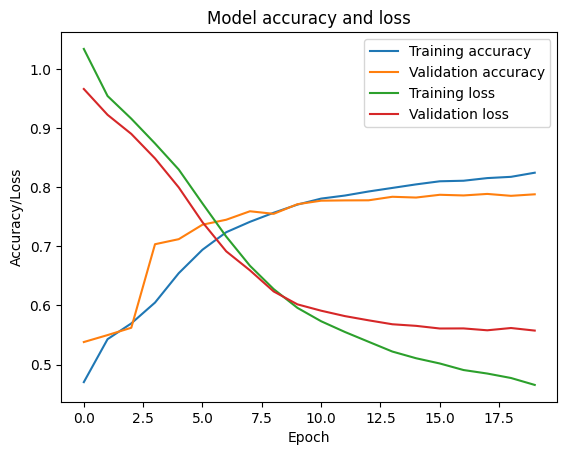

In [ ]:
# Plot the accuracyand loss curves
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model accuracy and loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()


In [ ]:
# Define function to predict sentiment of input text
def predict_sentiment(model, tokenizer, input_text):
    # Tokenize and pad the input text
    encoded_text = tokenizer.texts_to_sequences([input_text])
    padded_text = pad_sequences(encoded_text, maxlen=200)
    
    # Predict the sentiment using the trained model
    sentiment_prediction = model.predict(padded_text)
    
    # Return the predicted sentiment label
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_sentiment = sentiment_dict[np.argmax(sentiment_prediction)]
    return predicted_sentiment

# Take input text from user
while True:
    input_text = input("Enter the text to predict the sentiment: ")

    if input_text == "":
        break
    # Predict the sentiment label of the input text
    predicted_sentiment = predict_sentiment(model, tokenizer, input_text)

    # Print the predicted sentiment label
    print("Predicted sentiment: ", predicted_sentiment)

Enter the text to predict the sentiment: i love you but i hate you


NameError: ignored